# NBA Playoff Prediction - K-Nearest Neighbors

This notebook implements K-Nearest Neighbors (KNN) for predicting NBA playoff qualification.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load processed data
X_train = np.load('data/processed/X_train_scaled.npy')
X_val = np.load('data/processed/X_val_scaled.npy')
X_test = np.load('data/processed/X_test_scaled.npy')

y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")


Training set: X=(446, 32), y=(446,)
Validation set: X=(120, 32), y=(120,)
Test set: X=(120, 32), y=(120,)


## Model Evaluation


In [3]:
# Evaluate on train, validation, and test sets
def evaluate_knn(k, metric='euclidean', weights='uniform', X_train=X_train, y_train=y_train, 
                X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test):
    """
    Train and evaluate KNN model on train, validation, and test sets.
    """
    # Train model
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)
    
    results = {}
    
    # Evaluate on each set
    for name, X_data, y_data in [('train', X_train, y_train), 
                                  ('val', X_val, y_val), 
                                  ('test', X_test, y_test)]:
        y_pred = knn.predict(X_data)
        y_pred_proba = knn.predict_proba(X_data)[:, 1]
        
        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred, zero_division=0)
        rec = recall_score(y_data, y_pred, zero_division=0)
        f1 = f1_score(y_data, y_pred, zero_division=0)
        
        try:
            auc = roc_auc_score(y_data, y_pred_proba)
        except:
            auc = 0
        
        results[name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    return knn, results


## Hyperparameter Tuning


In [4]:
# Try different hyperparameter combinations
k_values = [1, 3, 5, 7, 9, 11, 15, 21]
metrics = ['euclidean', 'manhattan']
weights_options = ['uniform', 'distance']

results = []

print("Hyperparameter Tuning: Testing different K, metric, and weight combinations")
print("=" * 80)

for k in k_values:
    for metric in metrics:
        for weights in weights_options:
            # Train and evaluate on validation set
            knn, eval_results = evaluate_knn(k, metric, weights, 
                                           X_train, y_train, 
                                           X_val, y_val, 
                                           X_test, y_test)
            
            val_results = eval_results['val']
            
            results.append({
                'k': k,
                'metric': metric,
                'weights': weights,
                'accuracy': val_results['accuracy'],
                'precision': val_results['precision'],
                'recall': val_results['recall'],
                'f1': val_results['f1'],
                'auc': val_results['auc']
            })
            
            print(f"K={k:2d}, Metric={metric:10s}, Weights={weights:8s}: "
                  f"Acc={val_results['accuracy']:.4f}, F1={val_results['f1']:.4f}, "
                  f"AUC={val_results['auc']:.4f}")

# Find best model based on AUC score
results_df = pd.DataFrame(results)
best_idx = results_df['auc'].idxmax()
best_k = results_df.loc[best_idx, 'k']
best_metric = results_df.loc[best_idx, 'metric']
best_weights = results_df.loc[best_idx, 'weights']
best_auc = results_df.loc[best_idx, 'auc']

print(f"\nBest model (selected by AUC score): K={best_k}, Metric={best_metric}, Weights={best_weights} (AUC={best_auc:.4f})")
print(f"Validation metrics at best model:")
print(f"  Accuracy: {results_df.loc[best_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_idx, 'recall']:.4f}")
print(f"  F1 Score: {results_df.loc[best_idx, 'f1']:.4f}")
print(f"  AUC: {results_df.loc[best_idx, 'auc']:.4f}")


Hyperparameter Tuning: Testing different K, metric, and weight combinations
K= 1, Metric=euclidean , Weights=uniform : Acc=0.7833, F1=0.8060, AUC=0.7790
K= 1, Metric=euclidean , Weights=distance: Acc=0.7833, F1=0.8060, AUC=0.7790
K= 1, Metric=manhattan , Weights=uniform : Acc=0.8333, F1=0.8551, AUC=0.8270
K= 1, Metric=manhattan , Weights=distance: Acc=0.8333, F1=0.8551, AUC=0.8270
K= 3, Metric=euclidean , Weights=uniform : Acc=0.8167, F1=0.8451, AUC=0.8686
K= 3, Metric=euclidean , Weights=distance: Acc=0.8167, F1=0.8451, AUC=0.8687
K= 3, Metric=manhattan , Weights=uniform : Acc=0.8500, F1=0.8676, AUC=0.8952
K= 3, Metric=manhattan , Weights=distance: Acc=0.8500, F1=0.8676, AUC=0.9035
K= 5, Metric=euclidean , Weights=uniform : Acc=0.8083, F1=0.8369, AUC=0.8878
K= 5, Metric=euclidean , Weights=distance: Acc=0.8083, F1=0.8369, AUC=0.8896
K= 5, Metric=manhattan , Weights=uniform : Acc=0.8417, F1=0.8613, AUC=0.9025
K= 5, Metric=manhattan , Weights=distance: Acc=0.8417, F1=0.8613, AUC=0.9060


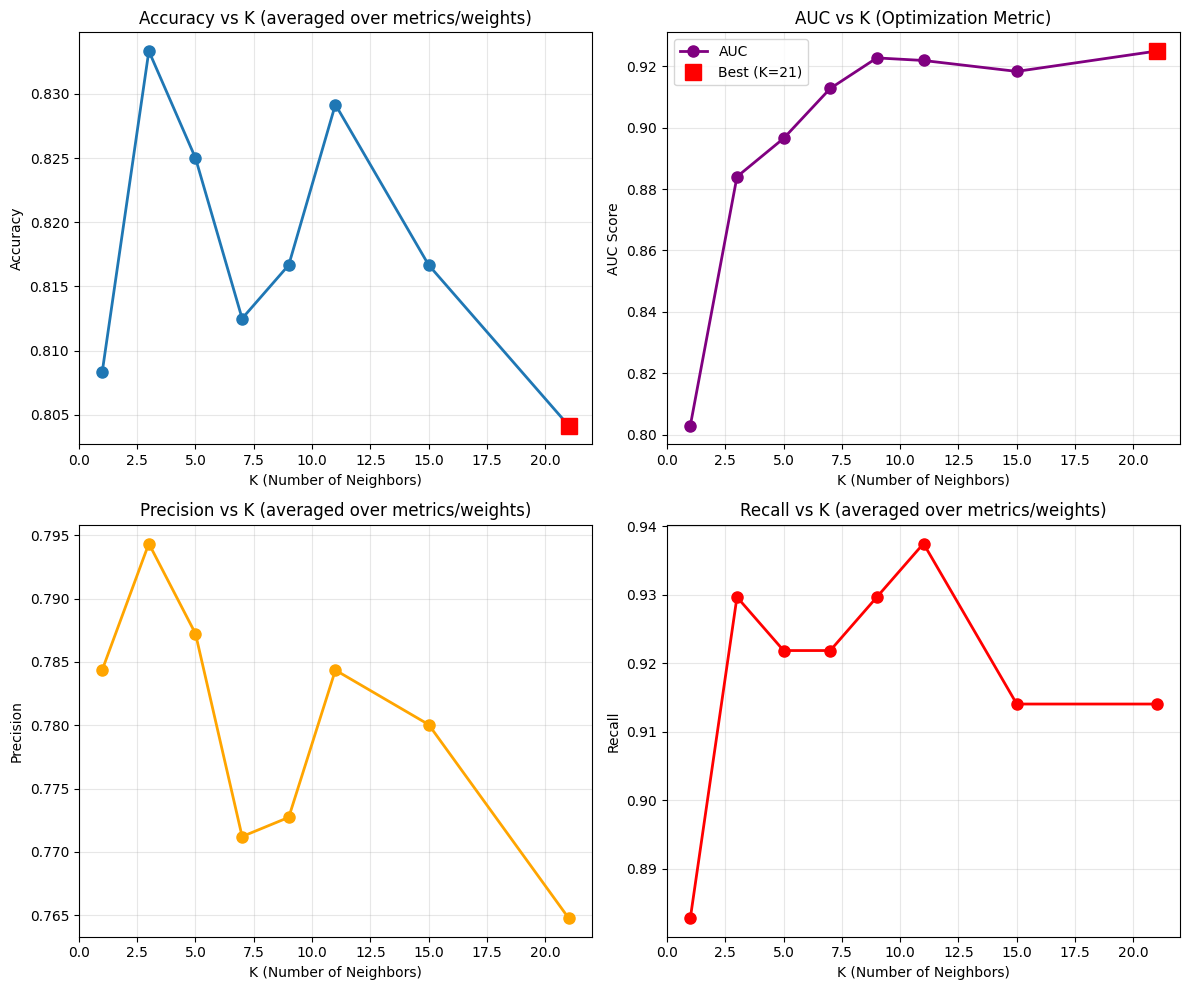

In [5]:
# Plot hyperparameter tuning results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Group by k and calculate mean metrics
k_summary = results_df.groupby('k').agg({
    'accuracy': 'mean',
    'f1': 'mean',
    'auc': 'mean',
    'precision': 'mean',
    'recall': 'mean'
}).reset_index()

# Find best k for highlighting
best_k_summary = k_summary[k_summary['k'] == best_k]

axes[0, 0].plot(k_summary['k'], k_summary['accuracy'], 'o-', linewidth=2, markersize=8)
axes[0, 0].plot(best_k, best_k_summary['accuracy'].values[0], 's', markersize=12, color='red', zorder=5)
axes[0, 0].set_xlabel('K (Number of Neighbors)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs K (averaged over metrics/weights)')
axes[0, 0].grid(True, alpha=0.3)

# AUC plot (optimization metric) - highlight best point
axes[0, 1].plot(k_summary['k'], k_summary['auc'], 'o-', linewidth=2, markersize=8, color='purple', label='AUC')
axes[0, 1].plot(best_k, best_k_summary['auc'].values[0], 's', markersize=12, color='red', label=f'Best (K={best_k})', zorder=5)
axes[0, 1].set_xlabel('K (Number of Neighbors)')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].set_title('AUC vs K (Optimization Metric)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].plot(k_summary['k'], k_summary['precision'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('K (Number of Neighbors)')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs K (averaged over metrics/weights)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_summary['k'], k_summary['recall'], 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].set_xlabel('K (Number of Neighbors)')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall vs K (averaged over metrics/weights)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Final Model with Best Hyperparameters


In [6]:
# Train final model with best hyperparameters (selected by AUC score on validation set)
print(f"Training final model with best hyperparameters: K={best_k}, Metric={best_metric}, Weights={best_weights} (AUC={best_auc:.4f} on validation)")

best_knn, final_results = evaluate_knn(best_k, best_metric, best_weights,
                                      X_train, y_train,
                                      X_val, y_val,
                                      X_test, y_test)

# Evaluate on test set
test_results = final_results['test']

print("\nFinal Test Set Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")
print(f"AUC: {test_results['auc']:.4f}")

cm = confusion_matrix(y_test, test_results['y_pred'])
print(f"\nConfusion Matrix:")
print(cm)


Training final model with best hyperparameters: K=21, Metric=manhattan, Weights=distance (AUC=0.9389 on validation)

Final Test Set Results:
Accuracy: 0.6667
Precision: 0.6154
Recall: 1.0000
F1 Score: 0.7619
AUC: 0.9481

Confusion Matrix:
[[16 40]
 [ 0 64]]


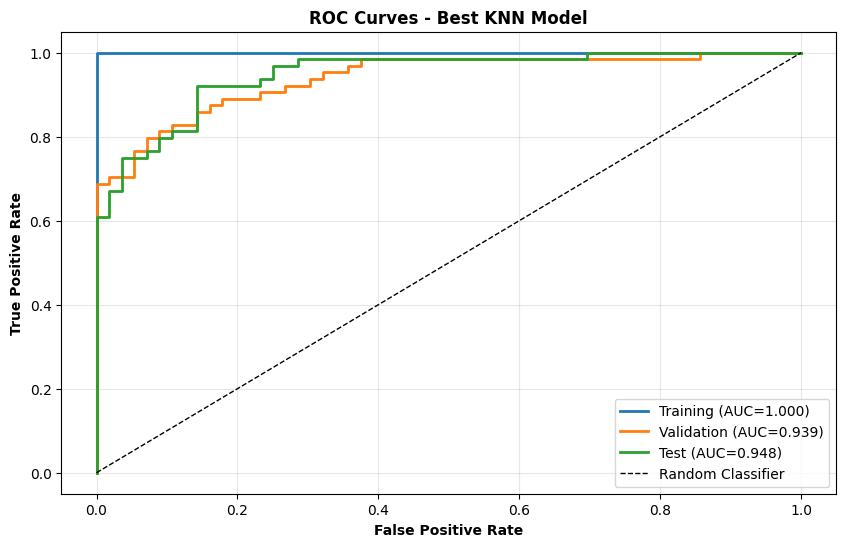

In [7]:
# ROC Curves for Train, Val, Test sets
plt.figure(figsize=(10, 6))

for name, results_dict in [('Training', final_results['train']),
                           ('Validation', final_results['val']),
                           ('Test', final_results['test'])]:
    y_true = y_train if name == 'Training' else (y_val if name == 'Validation' else y_test)
    y_prob = results_dict['y_pred_proba']
    
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
    except:
        pass

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves - Best KNN Model', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


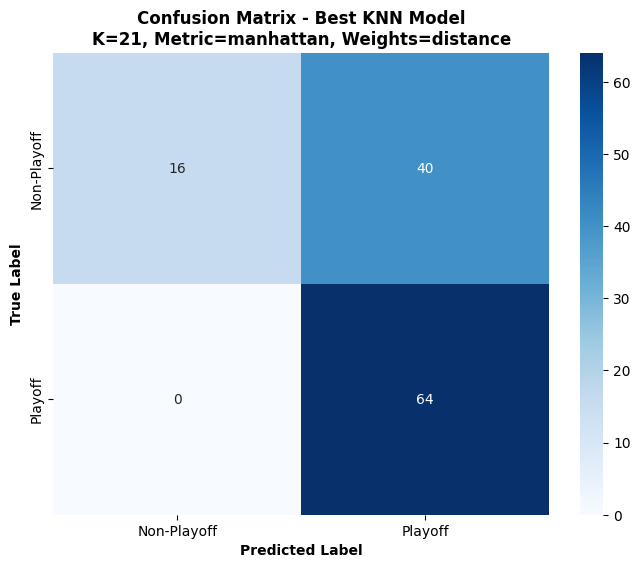

In [8]:
# Confusion Matrix Heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Playoff', 'Playoff'],
            yticklabels=['Non-Playoff', 'Playoff'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title(f'Confusion Matrix - Best KNN Model\nK={best_k}, Metric={best_metric}, Weights={best_weights}',
          fontweight='bold')
plt.show()


## Detailed Results


In [9]:
print("\n" + "=" * 80)
print("DETAILED RESULTS: KNN (Hyperparameter Sweep - Validation Set)")
print("=" * 80)
print("(Best model selected based on AUC)")
print("=" * 80)
# Sort by AUC to show best at top, then by k
results_df_sorted = results_df.sort_values(['auc', 'k'], ascending=[False, True])
print(results_df_sorted[['k', 'metric', 'weights', 'accuracy', 'precision', 'recall', 'f1', 'auc']].to_string(index=False))

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY K")
print("=" * 80)
k_stats = results_df.groupby('k').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(k_stats)

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY METRIC")
print("=" * 80)
metric_stats = results_df.groupby('metric').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(metric_stats)

print("\n" + "=" * 80)
print("PERFORMANCE (Validation) BY WEIGHTS")
print("=" * 80)
weights_stats = results_df.groupby('weights').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max']
}).round(4)
print(weights_stats)



DETAILED RESULTS: KNN (Hyperparameter Sweep - Validation Set)
(Best model selected based on AUC)
 k    metric  weights  accuracy  precision   recall       f1      auc
21 manhattan distance  0.816667   0.776316 0.921875 0.842857 0.938895
21 manhattan  uniform  0.816667   0.776316 0.921875 0.842857 0.935965
 9 manhattan distance  0.808333   0.766234 0.921875 0.836879 0.931362
 7 manhattan distance  0.800000   0.770270 0.890625 0.826087 0.927037
15 manhattan distance  0.816667   0.783784 0.906250 0.840580 0.926897
11 manhattan distance  0.833333   0.789474 0.937500 0.857143 0.926060
 7 manhattan  uniform  0.800000   0.770270 0.890625 0.826087 0.923968
11 manhattan  uniform  0.833333   0.789474 0.937500 0.857143 0.923689
15 manhattan  uniform  0.816667   0.783784 0.906250 0.840580 0.923410
11 euclidean distance  0.825000   0.779221 0.937500 0.851064 0.922712
 9 manhattan  uniform  0.808333   0.766234 0.921875 0.836879 0.922154
 9 euclidean distance  0.825000   0.779221 0.937500 0.851064 0